# Logistic Regression - Human Activity Recognition

En éste ejercicio vamos a reutilizar los resultados obtenidos con PCA para el dataset de Human Activity Recognition e intentar clasificar correctamente las muestras que denotan movimiento de las que no. Para más información sobre los datos, consultar la fuente [original](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones).

### Importamos las librerías

In [1]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use(['seaborn-darkgrid'])
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.family'] = 'DejaVu Sans'

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

RANDOM_STATE = 17

### Cargamos el dataset

In [3]:
PATH_DATASET = "data/UCI HAR Dataset/train"

In [27]:
X_train = np.loadtxt(os.path.join(PATH_DATASET, "X_train.txt"))
y_train = np.loadtxt(os.path.join(PATH_DATASET, "y_train.txt")).astype(int)

### EDA Mínimo

In [5]:
print("Estructura features del dataset: {}".format(X_train.shape))
print("Estructura de las etiquetas: {}".format(y_train.shape))

Estructura features del dataset: (7352, 561)
Estructura de las etiquetas: (7352,)


In [6]:
# Exploramos un poco las features
df = pd.DataFrame(data=X_train)
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,551,552,553,554,555,556,557,558,559,560
count,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,...,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000,7352.000000
mean,0.274488,-0.017695,-0.109141,-0.605438,-0.510938,-0.604754,-0.630512,-0.526907,-0.606150,-0.468604,...,0.125293,-0.307009,-0.625294,0.008684,0.002186,0.008726,-0.005981,-0.489547,0.058593,-0.056515
std,0.070261,0.040811,0.056635,0.448734,0.502645,0.418687,0.424073,0.485942,0.414122,0.544547,...,0.250994,0.321011,0.307584,0.336787,0.448306,0.608303,0.477975,0.511807,0.297480,0.279122
min,-1.000000,-1.000000,-1.000000,-1.000000,-0.999873,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-0.995357,-0.999765,-0.976580,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,0.262975,-0.024863,-0.120993,-0.992754,-0.978129,-0.980233,-0.993591,-0.978162,-0.980251,-0.936219,...,-0.023692,-0.542602,-0.845573,-0.121527,-0.289549,-0.482273,-0.376341,-0.812065,-0.017885,-0.143414
50%,0.277193,-0.017219,-0.108676,-0.946196,-0.851897,-0.859365,-0.950709,-0.857328,-0.857143,-0.881637,...,0.134000,-0.343685,-0.711692,0.009509,0.008943,0.008735,-0.000368,-0.709417,0.182071,0.003181
75%,0.288461,-0.010783,-0.097794,-0.242813,-0.034231,-0.262415,-0.292680,-0.066701,-0.265671,-0.017129,...,0.289096,-0.126979,-0.503878,0.150865,0.292861,0.506187,0.359368,-0.509079,0.248353,0.107659
max,1.000000,1.000000,1.000000,1.000000,0.916238,1.000000,1.000000,0.967664,1.000000,1.000000,...,0.946700,0.989538,0.956845,1.000000,1.000000,0.998702,0.996078,1.000000,0.478157,1.000000


In [7]:
df.isna().sum().sum()

0

In [28]:
# Cantidad única de clases
clases = np.unique(y_train)
clases

array([1, 2, 3, 4, 5, 6])

In [9]:
n_clases = clases.size

In [10]:
n_clases

6

|     Label     |   Descripción  | 
| ------------- |:-------------: |
|       1       | Caminar        | 
|       2       | Subir escaleras|
|       3       | Bajar escaleras|
|       4       | Estar sentado  |
|       5       | Estar parado   |
|       6       | Recostarse     |

### Aplicamos PCA

In [11]:
# Estandarizamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

Al aplicar PCA, es una práctica común reducir el número de dimensiones, dejando tantos componentes como sean necesarios para que contemplen al menos el 90% de la varianza de los datos escalados originales. Scikit-learn permite indicar directamente ese parámetro como condición. Si no se puede seleccionar un número alto de componentes y mediante un scree plot, verificar cuántos son necesarios para mantener un 90%.

In [12]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [13]:
# Cantidad de componentes necesarios
X_pca.shape[1]

63

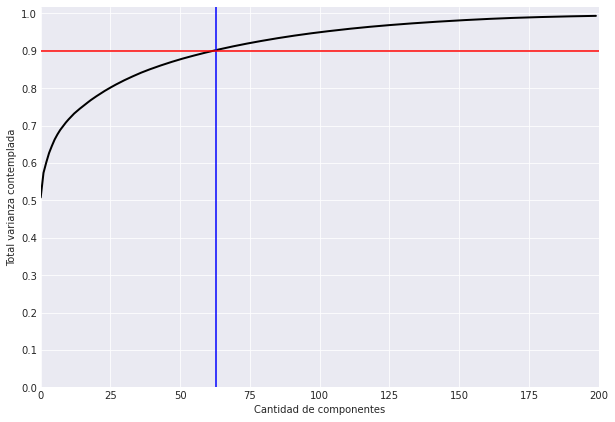

In [14]:
pca_2 = PCA(n_components=200, random_state=RANDOM_STATE).fit(X_scaled)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca_2.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Cantidad de componentes')
plt.ylabel('Total varianza contemplada')
plt.xlim(0, 200)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(63, c='b')
plt.axhline(0.9, c='r')
plt.show();

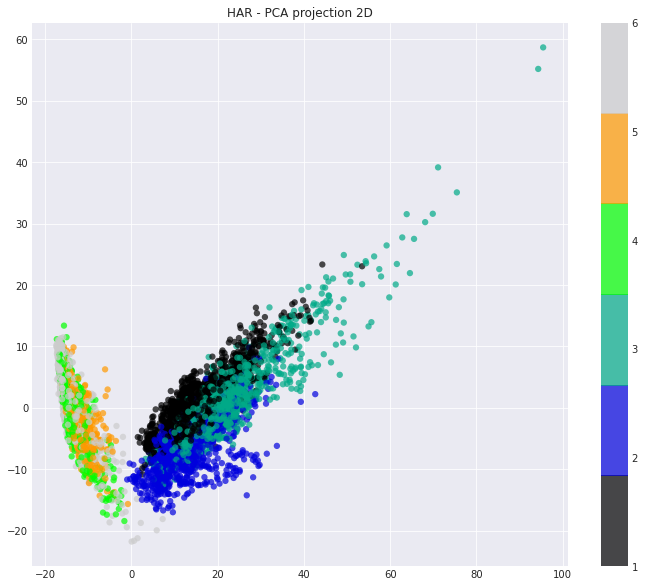

In [15]:
# Graficamos los primeros dos componentes
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('HAR - PCA projection 2D');

### Clusterización

In [16]:
kmeans = KMeans(n_clusters=n_clases, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

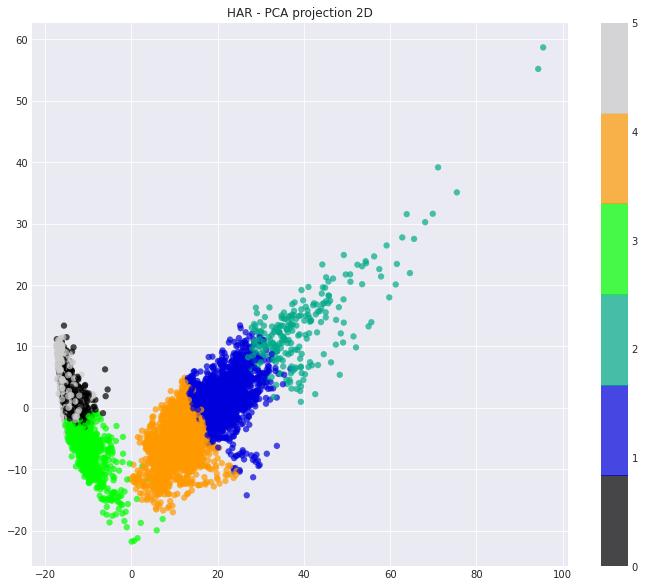

In [17]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 6))
plt.colorbar()
plt.title('HAR - PCA projection 2D');

In [18]:
kmeans_move = KMeans(n_clusters=2, n_init=100, random_state=RANDOM_STATE)
kmeans_move.fit(X_pca)
cluster_labels_mov = kmeans_move.labels_

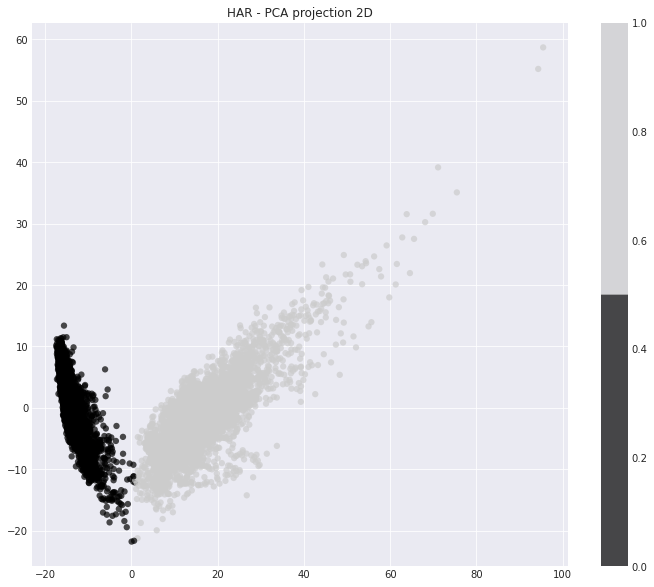

In [19]:
# Graficamos los primeros dos componentes - clusters id
plt.figure(figsize=(12,10))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels_mov, edgecolor='none', alpha=0.7, s=40, cmap=plt.cm.get_cmap('nipy_spectral', 2))
plt.colorbar()
plt.title('HAR - PCA projection 2D');

In [20]:
tab = pd.crosstab(y_train, cluster_labels, margins=True)
tab.index = ['Caminar', 'Subir escaleras', 'Bajar escaleras', 'Estar parado', 'Estar sentado', 'Recostarse', 'Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(6)] + ['Todos']
tab

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,Todos
Caminar,0,512,68,0,646,0,1226
Subir escaleras,0,209,5,2,857,0,1073
Bajar escaleras,0,620,166,0,200,0,986
Estar parado,884,0,0,315,1,86,1286
Estar sentado,999,0,0,375,0,0,1374
Recostarse,26,0,0,270,4,1107,1407
Todos,1909,1341,239,962,1708,1193,7352


In [21]:
tab = pd.crosstab(y_train, cluster_labels_mov, margins=True)
tab.index = ['Caminar', 'Subir escaleras', 'Bajar escaleras', 'Estar parado', 'Estar sentado', 'Recostarse', 'Todos']
tab.columns = ['cluster ' + str(i + 0) for i in range(2)] + ['Todos']
tab

,cluster 0,cluster 1,Todos
Caminar,0,1226,1226
Subir escaleras,8,1065,1073
Bajar escaleras,0,986,986
Estar parado,1285,1,1286
Estar sentado,1374,0,1374
Recostarse,1396,11,1407
Todos,4063,3289,7352


---

## Clasificación

Se puede observar en el gráfico de los primeros dos componentes de PCA, y en los resultados de la clusterización por K-means con dos clusters, que potencialmente se podrían separar con los dos primeros componentes, los estados de movimiento respecto de los estados en reposo. 

In [35]:
y_train[0:5]

array([5, 5, 5, 5, 5])

In [32]:
# Armamos máscaras para mapear las actividades a reposo (1) o movimiento (0)
# y = {1, 2, 3} => 0, y = {4, 5, 6} => 1 

act_mask = y_train <= 3
st_mask = y_train > 3

In [36]:
st_mask[:5]

array([ True,  True,  True,  True,  True])

In [37]:
y_class_train = y_train.copy()

y_class_train[act_mask] = 0
y_class_train[st_mask] = 1

In [39]:
y_class_train[:5]

array([1, 1, 1, 1, 1])

In [44]:
y_class_train.shape

(7352,)

In [42]:
x_class_train = X_pca[:, :2]

In [43]:
x_class_train.shape

(7352, 2)

### Creamos el Modelo

In [45]:
import sys  
sys.path.insert(0, 'C:/Users/Lautaro/PycharmProjects/ceia_intro_a_IA/clase_3/ejercicios/src')

In [46]:
from models import BaseModel
from metrics import Accuracy, Precision, Recall

In [47]:
class LogisticRegression(BaseModel):
    
    # definimos la función sigmoid para entrenamiento y las predicciones
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    # definimos la función loss para reportarla cada cierta cantidad de epochs
    def loss(self, y, y_hat):
        loss = np.mean(-y*(np.log(y_hat)) - (1-y)*np.log(1-y_hat))
        return loss 

    def fit(self, X, y, lr, b, epochs, bias=True, log=100, verbose=True):

        # si decidimos utilizar bias, agregamos como siempre una columna con '1' al dataset de entrada
        if bias:
            X = np.hstack((np.ones((X.shape[0], 1)), X))

        # inicializamos aleatoriamente los pesos
        m = X.shape[1]
        W = np.random.randn(m).reshape(m, 1)

        loss_list = []
        
        # corremos Mini-Batch para optimizar los parámetros
        for j in range(epochs):
            idx = np.random.permutation(X.shape[0])
            X_train = X[idx]
            y_train = y[idx]
            batch_size = int(len(X_train) / b)

            for i in range(0, len(X_train), batch_size):
                end = i + batch_size if i + batch_size <= len(X_train) else len(X_train)
                batch_X = X_train[i: end]
                batch_y = y_train[i: end]

                prediction = self.sigmoid(np.sum(np.transpose(W) * batch_X, axis=1))
                error = prediction.reshape(-1, 1) - batch_y.reshape(-1, 1)
                grad_sum = np.sum(error * batch_X, axis=0)
                grad_mul = 1 / batch_size * grad_sum
                gradient = np.transpose(grad_mul).reshape(-1, 1)

                W = W - (lr * gradient)
            
            l_epoch = self.loss(y_train, self.sigmoid(np.dot(X_train, W)))
            loss_list.append(l_epoch)
            if verbose:
                if j%log==0:
                    print("Epoch: {}, Loss: {}".format(j, l_epoch))
                
        self.model = W
        self.losses = loss_list

    def predict(self, X):
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        p = self.sigmoid(X @ self.model)
        mask_true = p >= 0.5
        mask_false = p < 0.5
        p[mask_true] = 1
        p[mask_false] = 0
        return p

In [52]:
# Seleccionar hiperparámetros
lr = 0.01
b = 16
epochs = 10000
bias = True

# Hacer el fit del modelo con los HPs seleccionados
logistic_regression = LogisticRegression()
logistic_regression.fit(x_class_train, y_class_train.reshape(-1, 1), lr, b, epochs, bias, log=500)
print(logistic_regression.model)

Epoch: 0, Loss: 0.08494838835578909
Epoch: 500, Loss: 0.011359164462439026
Epoch: 1000, Loss: 0.011271439081127342
Epoch: 1500, Loss: 0.011191565393267306
Epoch: 2000, Loss: 0.01111480228770575
Epoch: 2500, Loss: 0.011041048011465993
Epoch: 3000, Loss: 0.010970245012872006
Epoch: 3500, Loss: 0.010902319138426089
Epoch: 4000, Loss: 0.010837211999041143
Epoch: 4500, Loss: 0.010774855234011092
Epoch: 5000, Loss: 0.010715178944229985
Epoch: 5500, Loss: 0.01065811340903197
Epoch: 6000, Loss: 0.01060358808876456
Epoch: 6500, Loss: 0.010551532715900798
Epoch: 7000, Loss: 0.010501870350101514
Epoch: 7500, Loss: 0.010454530198028538
Epoch: 8000, Loss: 0.010409442108901906
Epoch: 8500, Loss: 0.010366522524797908
Epoch: 9000, Loss: 0.010325705133347698
Epoch: 9500, Loss: 0.010286912897154775
[[-0.13443327]
 [-0.7812367 ]
 [-0.05045896]]


### Decision Boundary para Dataset de Train

In [53]:
# Calculamos el slope e intercept para graficar
slope = -(logistic_regression.model[1] / logistic_regression.model[2])
intercept = -(logistic_regression.model[0] / logistic_regression.model[2])

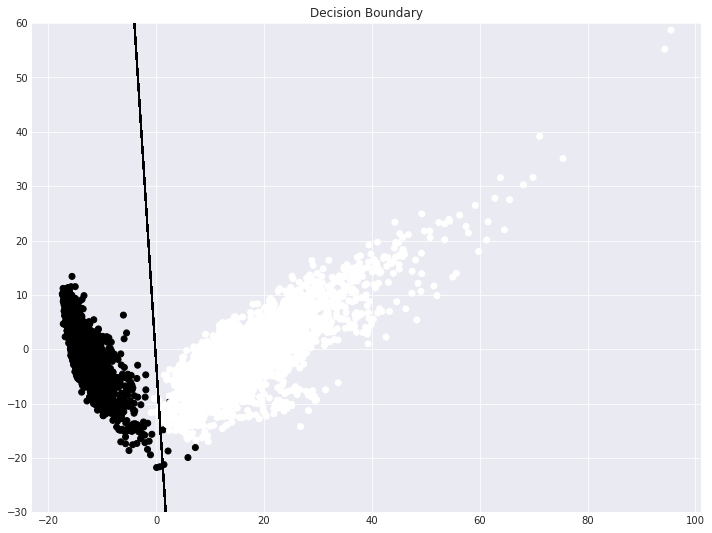

In [56]:
# Graficos

plt.scatter(x_class_train[:, 0], x_class_train[:, 1], c=y_class_train[:])
y_vals = intercept + (slope * x_class_train[:, 0])
plt.plot(x_class_train[:, 0], y_vals, c="k")
plt.title('Decision Boundary')
plt.ylim((-30, 60))
plt.show()

### Predicciones sobre el Dataset de Test

In [57]:
# Cargamos el dataset de test

PATH_DATASET = "data/UCI HAR Dataset/test"

X_test = np.loadtxt(os.path.join(PATH_DATASET, "X_test.txt"))
y_test = np.loadtxt(os.path.join(PATH_DATASET, "y_test.txt")).astype(int)

In [58]:
X_test.shape

(2947, 561)

In [59]:
# Debemos aplicar las mismas transformaciones sobre el dataset de test que se
# realizaron al dataset de train

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
x_class_test = X_test_pca[:, :2]

In [60]:
x_class_test.shape

(2947, 2)

In [61]:
# Armamos máscaras para mapear las actividades a reposo (1) o movimiento (0)
# y = {1, 2, 3} => 0, y = {4, 5, 6} => 1 

act_mask = y_test <= 3
st_mask = y_test > 3

In [62]:
y_class_test = y_test.copy()

y_class_test[act_mask] = 0
y_class_test[st_mask] = 1

In [63]:
y_class_test.shape

(2947,)

In [64]:
predictions = logistic_regression.predict(x_class_test)

### Calculamos las Métricas

In [65]:
metrics = [Accuracy(), Precision(), Recall()]
results = {}
for metric in metrics:
    name = metric.__class__.__name__
    results[name] = metric(y_class_test, predictions[:, 0])
    print('{metric}: {value}'.format(metric=name, value=results[name]))

Accuracy: 0.9989820156090939
Precision: 0.9993585631815266
Recall: 0.9987179487179487


### Graficamos los resultados

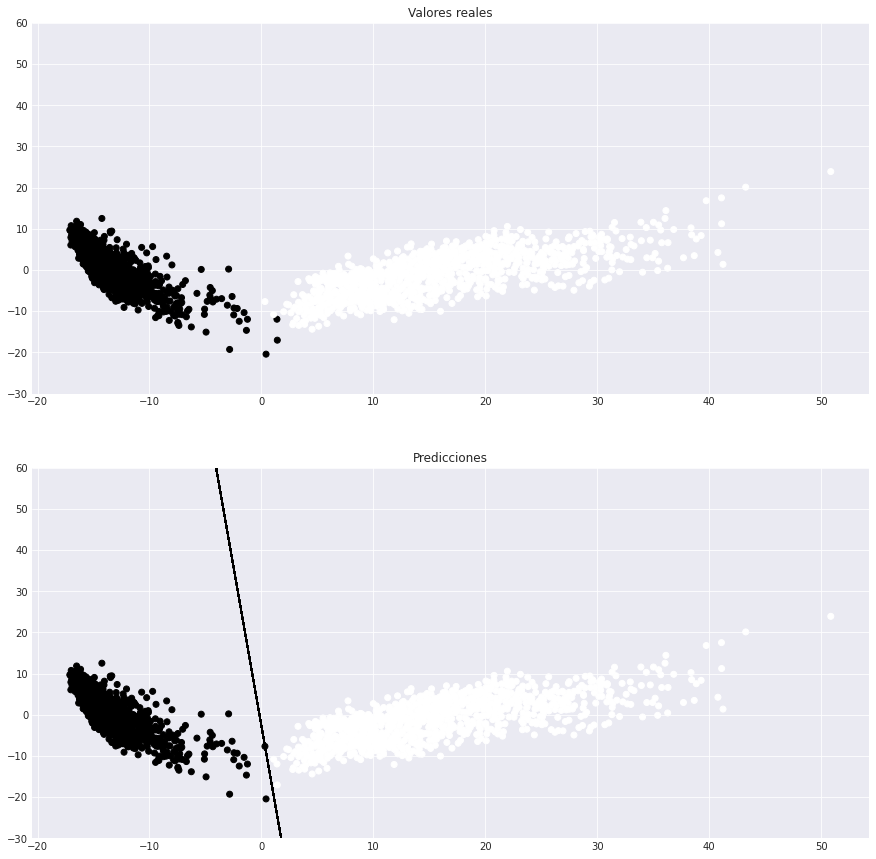

In [67]:
# Graficos

f, (ax, bx) = plt.subplots(2, 1, sharey='col', figsize=(15, 15))

ax.scatter(x_class_test[:, 0], x_class_test[:, 1], c=y_class_test)
ax.set_title('Valores reales')
ax.set_ylim((-30, 60))

bx.scatter(x_class_test[:, 0], x_class_test[:, 1], c=predictions[:, 0])
y_vals = intercept + (slope * x_class_test[:, 0])
bx.plot(x_class_test[:, 0], y_vals, c="k")
bx.set_title('Predicciones')
bx.set_ylim((-30, 60))

plt.show()

---

### Bibliografía

* [Información sobre el dataset](https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones)